In [1]:
import os
import sys

BACKTESTER_DIR = os.path.realpath(os.path.join(os.getcwd(), '..', '..'))
DATA_DIR = os.path.join(BACKTESTER_DIR, 'data')
OPTIONS_DATA = os.path.join(DATA_DIR, 'options_data_clean_v2.h5')
STOCKS_DATA = os.path.join(DATA_DIR, 'ivy_5assets.csv')

sys.path.append(BACKTESTER_DIR) # Add backtester base dir to $PYTHONPATH

In [2]:
%config InlineBackend.figure_format="retina"
%matplotlib inline
import pyfolio as pf
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (14, 8)

/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In this example we run a backtest consisting of 97% allocation in the ivy portfolio, taken from [the book of the same name](https://www.amazon.es/Ivy-Portfolio-Invest-Endowments-Markets/dp/1118008855), and 3% in buying both a call and a put with $\geq 60$ dte; the backtest will run through the 2010-2018 period. The ivy portfolio is made up of an equal allocation in domestic stocks (VTI), foreign stocks (VEU), bonds (BND), real estate (VNQ) and commodities (DBC).

In [3]:
from backtester.datahandler import HistoricalOptionsData, TiingoData
from backtester.strategy import Strategy, StrategyLeg
from backtester import Backtest, Stock, Type, Direction

In [4]:
stocks_data = TiingoData(STOCKS_DATA)
stocks_data._data = stocks_data._data.query('date <= "2018-12-31"')

stocks = [Stock('VTI', 0.2), Stock('VEU', 0.2), Stock('BND', 0.2), Stock('VNQ', 0.2), Stock('DBC', 0.2)]

In [5]:
options_data = HistoricalOptionsData(
        OPTIONS_DATA,
        key="/SPX",
        where='quotedate >= "2010-01-01"')
options_schema = options_data.schema

In [6]:
strat = Strategy(options_schema)

leg_1 = StrategyLeg("leg_1", options_schema, option_type=Type.PUT, direction=Direction.BUY)
leg_1.entry_filter = (options_schema.underlying == "SPX") & (options_schema.dte >= 60)
leg_1.exit_filter = (options_schema.dte <= 30)

leg_2 = StrategyLeg("leg_2", options_schema, option_type=Type.CALL, direction=Direction.BUY)
leg_2.entry_filter = (options_schema.underlying == "SPX") & (options_schema.dte >= 60)
leg_2.exit_filter = (options_schema.dte <= 30)
strat.add_legs([leg_1, leg_2]);

In [7]:
allocation = {'stocks': 0.97, 'options': 0.03, 'cash': 0}

In [8]:
bt = Backtest(allocation)
bt.options_data = options_data
bt.options_strategy = strat
bt.stocks = stocks
bt.stocks_data = stocks_data

In [9]:
bt.run(rebalance_freq=1)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:58


leg_1                                                        \
               contract underlying expiration type  strike    cost      order   
0    SPV100320P00200000        SPX 2010-03-20  put   200.0     5.0  Order.BTO   
1    SZU100417P00400000        SPX 2010-04-17  put   400.0     5.0  Order.BTO   
2    SPV100320P00200000        SPX 2010-03-20  put   200.0    -0.0  Order.STC   
3    SPQ100430P01000000        SPX 2010-04-30  put  1000.0   540.0  Order.BTO   
4    SZU100417P00400000        SPX 2010-04-17  put   400.0    -0.0  Order.STC   
..                  ...        ...        ...  ...     ...     ...        ...   
186  SPX181116P02440000        SPX 2018-11-17  put  2440.0   640.0  Order.BTO   
187  SPX181116P02440000        SPX 2018-11-17  put  2440.0  -260.0  Order.STC   
188  SPX181116P02440000        SPX 2018-11-17  put  2440.0  -180.0  Order.STC   
189  SPX190118P02310000        SPX 2019-01-19  put  2310.0  1180.0  Order.BTO   
190  SPX190118P02310000        SPX 2019-01-19  put  2310.0  -275.0  Order.STC   

                  leg_2                                               \
               contract underlying expiration  type  strike     cost   
0    SPQ100320C01040000        SPX 2010-03-20  call  1040.0  10530.0   
1    SXB100417C00990000        SPX 2010-04-17  call   990.0  11100.0   
2    SPQ100320C01040000        SPX 2010-03-20  call  1040.0  -7570.0   
3    SPQ100430C01000000        SPX 2010-04-30  call  1000.0  11920.0   
4    SXB100417C00990000        SPX 2010-04-17  call   990.0 -18670.0   
..                  ...        ...        ...   ...     ...      ...   
186  SPX181116C02440000        SPX 2018-11-17  call  2440.0  46580.0   
187  SPX181116C02440000        SPX 2018-11-17  call  2440.0 -48610.0   
188  SPX181116C02440000        SPX 2018-11-17  call  2440.0 -29520.0   
189  SPX190118C02310000        SPX 2019-01-19  call  2310.0  44270.0   
190  SPX190118C02310000        SPX 2019-01-19  call  2310.0 -48250.0   

                 totals                  
         order     cost  qty       date  
0    Order.BTO  10535.0  2.0 2010-01-04  
1    Order.BTO  11105.0  1.0 2010-02-01  
2    Order.STC  -7570.0  2.0 2010-03-01  
3    Order.BTO  12460.0  1.0 2010-03-01  
4    Order.STC -18670.0  1.0 2010-04-01  
..         ...      ...  ...        ...  
186  Order.BTO  47220.0  1.0 2018-09-04  
187  Order.STC -48870.0 -1.0 2018-10-01  
188  Order.STC -29700.0  0.0 2018-11-01  
189  Order.BTO  45450.0  1.0 2018-11-01  
190  Order.STC -48525.0 -1.0 2018-12-03  

[191 rows x 17 columns]

In [10]:
bt.balance

,total capital,cash,VTI,VEU,BND,VNQ,DBC,options qty,calls capital,puts capital,stocks qty,VTI qty,VEU qty,BND qty,VNQ qty,DBC qty,options capital,stocks capital,% change,accumulated return
2010-01-03,1.000000e+06,1000000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,NaN,NaN
2010-01-04,9.993900e+05,9035.176132,193994.584880,193978.372707,193969.039215,193974.318110,193978.508955,2.0,20460.0,0.0,27621.0,4111.0,5802.0,3307.0,6490.0,7911.0,20460.0,9.698948e+05,-0.000610,0.999390
2010-01-05,1.001132e+06,9035.176132,194739.285782,193935.228051,194536.303230,193756.614049,194209.069781,2.0,20920.0,0.0,27621.0,4111.0,5802.0,3307.0,6490.0,7911.0,20920.0,9.711765e+05,0.001743,1.001132
2010-01-06,1.005185e+06,9035.176132,195010.086110,194781.726199,194462.344427,193408.287552,197667.482183,2.0,20820.0,0.0,27621.0,4111.0,5802.0,3307.0,6490.0,7911.0,20820.0,9.753299e+05,0.004049,1.005185
2010-01-07,1.005012e+06,9035.176132,195822.487094,193633.215460,194314.426823,195498.246535,195208.166697,2.0,21500.0,0.0,27621.0,4111.0,5802.0,3307.0,6490.0,7911.0,21500.0,9.744765e+05,-0.000172,1.005012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,1.405689e+06,43713.671631,250608.785308,270408.136031,301290.815831,262182.757970,277484.922229,0.0,0.0,0.0,35765.0,2134.0,6316.0,3938.0,3785.0,19592.0,0.0,1.361975e+06,-0.015197,1.405689
2018-12-26,1.438276e+06,43713.671631,262668.155428,276644.091236,300640.987885,270953.856647,283655.538984,0.0,0.0,0.0,35765.0,2134.0,6316.0,3938.0,3785.0,19592.0,0.0,1.394563e+06,0.023182,1.438276
2018-12-27,1.438861e+06,43713.671631,265033.969358,276949.775315,301290.815831,270917.310403,280955.894153,0.0,0.0,0.0,35765.0,2134.0,6316.0,3938.0,3785.0,19592.0,0.0,1.395148e+06,0.000407,1.438861
2018-12-28,1.439344e+06,43713.671631,264698.986854,278478.195708,302017.094123,271794.420271,278641.912870,0.0,0.0,0.0,35765.0,2134.0,6316.0,3938.0,3785.0,19592.0,0.0,1.395631e+06,0.000336,1.439344


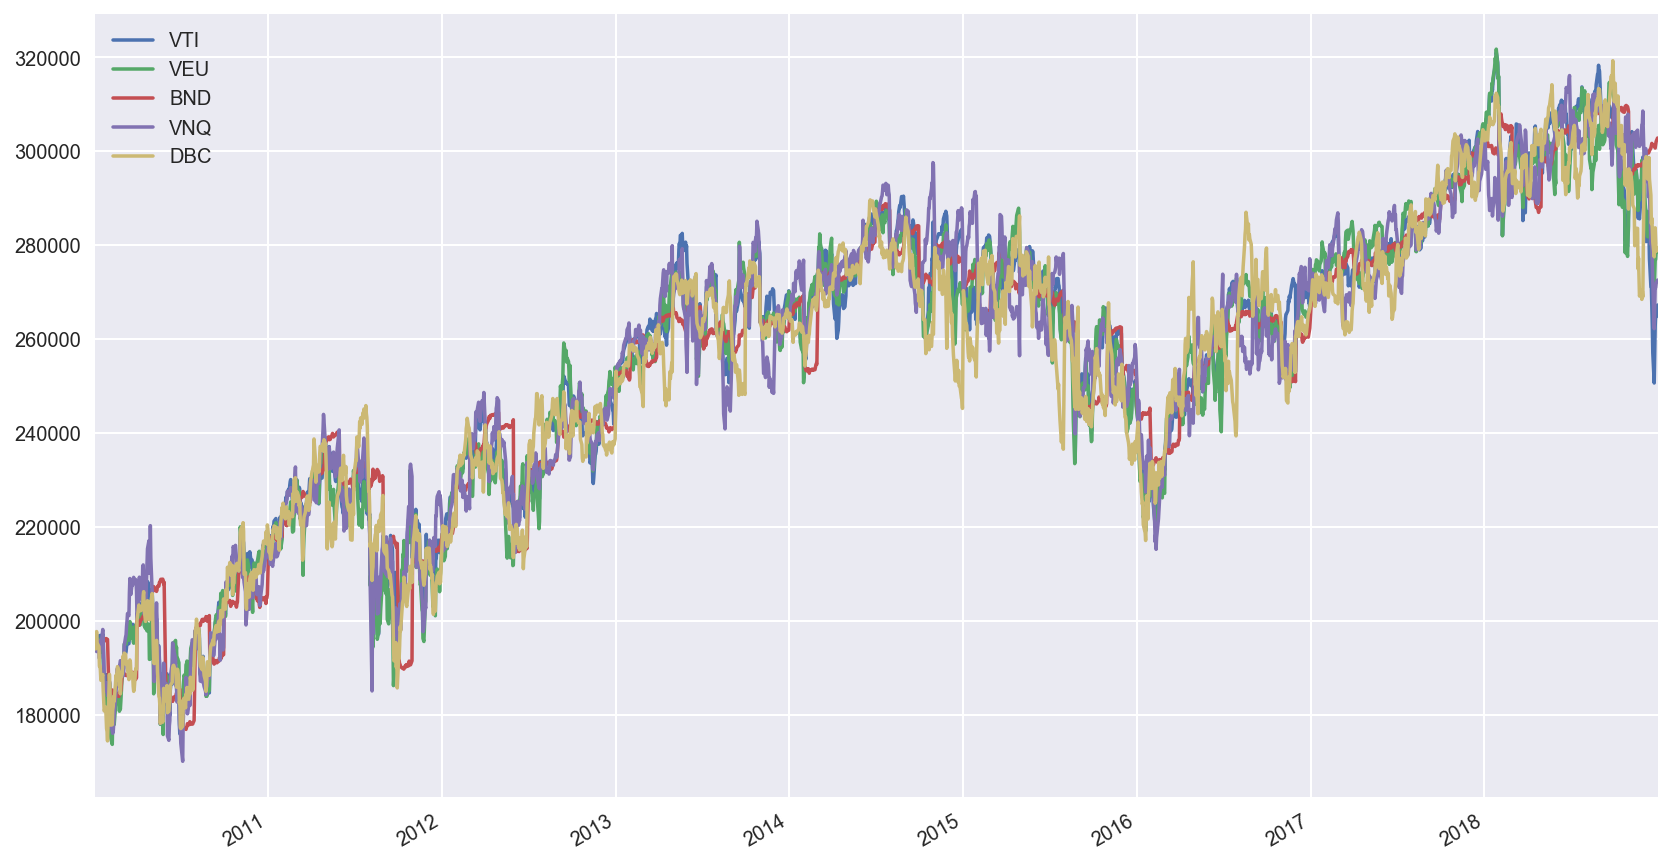

In [11]:
bt.balance[[stock.symbol for stock in stocks]].plot();

Start date,2010-01-04
End date,2018-12-31
Total months,107
,Backtest
Annual return,4.2%
Cumulative returns,44.4%
Annual volatility,13.9%
Sharpe ratio,0.36
Calmar ratio,0.18
Stability,0.73
Max drawdown,-23.3%


/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.26,2014-07-03,2016-02-11,2017-09-11,833
1,19.36,2011-04-29,2011-10-03,2012-03-13,228
2,14.63,2010-04-26,2010-07-02,2010-10-05,117
3,12.69,2018-01-26,2018-12-24,NaT,NaN
4,10.89,2013-05-21,2013-06-24,2014-06-18,282


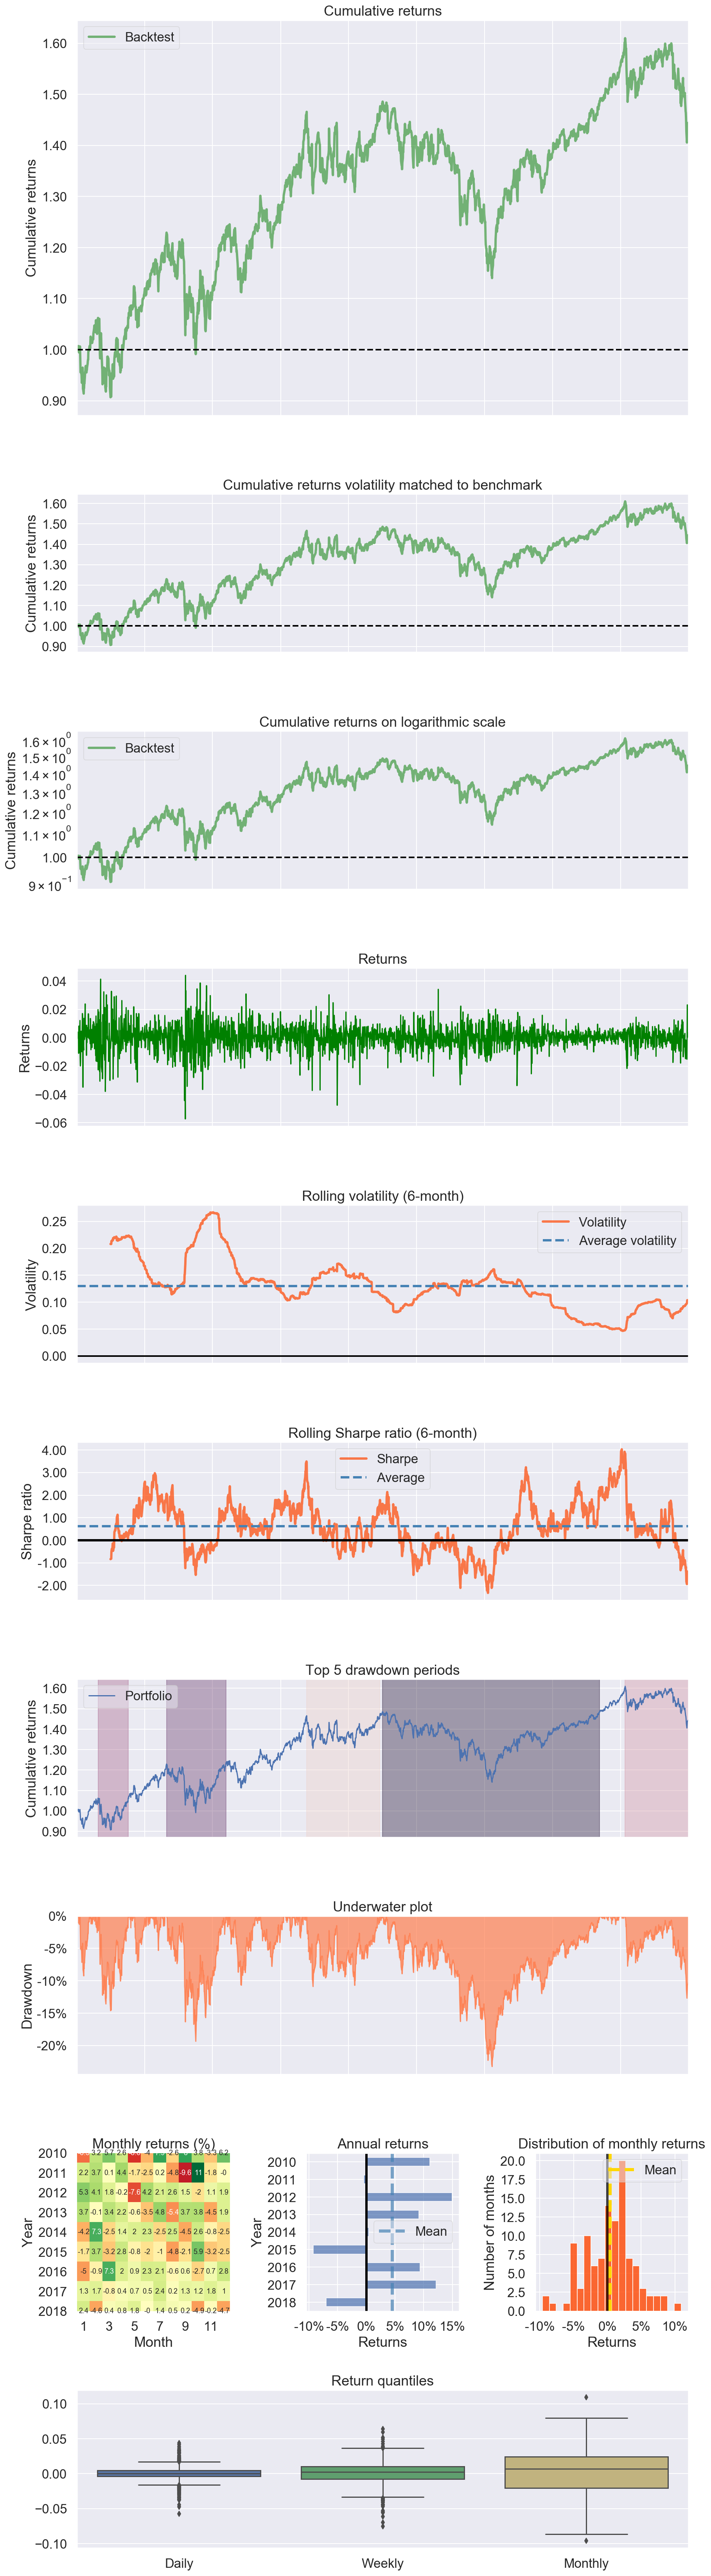

In [15]:
pf.create_returns_tear_sheet(returns=bt.balance['% change'].dropna())